# GA project week 6: Movies success analysis
### Grégory Vial - November 19th 2016

## Problem statement
Over the past decades, the amount of video content available to watch has literally boomed. 

From a handful TV channels in the eighties, people now have the choice between hundreds of TV channels, over 1 billion YouTube videos and nearly the whole history of movies and series on Netflix or other paying streaming platforms.

In this context, standing out as a content producer or finding out what to watch as a "consumer" has become harder and harder. As a result recommendations systems have become crucial in this new content jungle. It helps improve visibility of content which results in more views, and helps the public to identify more easily content they will enjoy.

But one question one might ask in the first place is obviously, what makes a movie successful?

## Goals
In this week's project, we intend to analyse the criteria that impact movie ratings.

IMDB (Internet movie database) is a website launched in 1996 where internet users can rate and comment movies, TV series and other video contents such as documentaries.

Based on the list of the 250 best rated movies on IMDB, plus a user list of 1000 best movies, plus some movies picked randomly in IMDB, we will observe various features and identify which ones play a role in the movie sucess. We intend to identify a few of these features in order of importance, and produce a recommendation for film producers so they know how to enhance their future movies ratings.

## Risks and assumptions
It is worth noting that IMBD belongs to Amazon, a company that intends to become a major player on the streaming market, and therefore a direct competitor of Netflix (just to name this one).

As a content provider, ratings provided by Amazon may be biased since the company has an interest in highly rating movies so they are watched by more people, and hence generating more revenue.

Such a biased has been observed and well documented for the Fandango review web site, see the article on FiveTheiryEight [website](http://fivethirtyeight.com/features/fandango-movies-ratings/) 

Other data sources may also provide different movie ratings and therefore the studied information should be considered not as the sole version of the truth, but rather a biased version of it.

Finally, we assume that the information recorded and made available to us by IMBD, in particular the movie features (director, actors, date of release etc) are accurate.

## Results
The results for this project have been documented on my [blog](http://ds.gregvi.al)

## Acquire the data
In this section we will scrape the IMBD using an [API](https://github.com/richardasaurus/imdb-pie) developed by Richard O'Dwyer.

In [1]:
## Initialise the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function,division

In [2]:
## Initialize the API
from imdbpie import Imdb
imdb = Imdb()
imdb = Imdb(anonymize=True)

### Scrape the 250 best rated IMDB movies

In [3]:
## Load the data into a pandas dataframe for ease of manipulation
top250 = imdb.top_250()
df = pd.DataFrame(top250)

In [4]:
df.head(2)

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1730102,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1182223,9.2,tt0068646,The Godfather,feature,1972


In [5]:
df.tail(2)

,can_rate,image,num_votes,rating,tconst,title,type,year
248,True,{u'url': u'https://images-na.ssl-images-amazon...,511947,8.0,tt3659388,The Martian,feature,2015
249,True,{u'url': u'https://images-na.ssl-images-amazon...,102741,8.1,tt0092067,Castle in the Sky,feature,1986


In [6]:
## Drop useless columns
## We can drop can_rate and type as the value is similar for all rows
## We can drop num_votes as this is not a feature of the movie, but rather an outcome
## We can drop image as we won't be analysing images in this project
df.drop(['can_rate','image','num_votes','type'],axis=1,inplace=True)

In [7]:
## Identify what additional information is available to us in IMBD that might be worth including
title = imdb.get_title_by_id("tt0111161")
dir(title)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_extract_cast_summary',
 '_extract_cover_url',
 '_extract_creators',
 '_extract_credits',
 '_extract_directors_summary',
 '_extract_trailer_image_urls',
 '_extract_trailers',
 '_extract_writers_summary',
 '_extract_year',
 'cast_summary',
 'certification',
 'cover_url',
 'creators',
 'credits',
 'directors_summary',
 'genres',
 'imdb_id',
 'plot_outline',
 'plots',
 'poster_url',
 'rating',
 'release_date',
 'runtime',
 'tagline',
 'title',
 'trailer_image_urls',
 'trailers',
 'type',
 'votes',
 'writers_summary',
 'year']

In [8]:
## Include cast_summary,directors_summary, genres, plot_outline, release date, runtime, tagline, writers_summary
cols = ['cast1','cast2','cast3','cast4','director','genre1','genre2','plot','date','runtime','tagline','writers']

In [9]:
## Define movie features extraction functions

def get_rating(movie):
    rating = np.nan
    try:
        #print('%s %s' % (movie.rating,type(movie.rating)))
        rating = float(movie.rating)
        #print('%s %s' % (rating,type(rating)))
    except:
        pass
    return(rating)

def get_director(movie):
    director = np.nan
    try:
        director = movie.directors_summary[0].name
    except:
        pass
    return(director)

def get_runtime(movie):
    runtime = np.nan
    try:
        runtime = int(movie.runtime/60)
    except:
        pass
    return(runtime)

def get_writer(movie):
    writer = np.nan
    try:
        writer = movie.writers_summary[0].name
    except:
        pass
    return(writer)

def get_cast(movie):
    actors = []
    for i in range(4):
        try:
            actors.append(movie.cast_summary[i].name)
        except:
            actors.append(np.nan)
    return(tuple(actors[:4]))

def get_genre(movie):
    genres = []
    for i in range(2):
        try:
            genres.append(movie.genres[i])
        except:
            genres.append(np.nan)
    return(tuple(genres[:2]))

In [10]:
## Create a dataframe of additional features
features= pd.DataFrame(columns=cols)
row=[]
count=0
for id in df.tconst:
    count += 1
    title = imdb.get_title_by_id(id)
    #print("Processing movie %d:  %s" % (count, title.title))
    cast1,cast2,cast3,cast4 = get_cast(title)
    director = title.directors_summary[0].name
    genre1,genre2 = get_genre(title)
    plot = title.plot_outline
    date = title.release_date
    runtime = int(title.runtime/60)
    tagline = title.tagline
    writers = title.writers_summary[0].name
    row = [cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers]
    row = np.reshape(row,(1,-1))
    row = pd.DataFrame(row,columns=cols)
    features = features.append(row)

In [11]:
## Convert columns appropriately
features.date = pd.to_datetime(features.date)
features.reset_index(inplace=True, drop=True)

In [12]:
features.tail(2)

,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers
248,Matt Damon,Jessica Chastain,Kristen Wiig,Kate Mara,Ridley Scott,Adventure,Drama,An astronaut becomes stranded on Mars after hi...,2015-10-02,144,Bring Him Home,Drew Goddard
249,Anna Paquin,Keiko Yokozawa,Mayumi Tanaka,James Van Der Beek,Hayao Miyazaki,Animation,Adventure,A young boy and a girl with a magic crystal mu...,1986-08-02,125,None,Hayao Miyazaki


In [13]:
## Concat the main dataframe with the features dataframe
top250 = pd.concat([df,features],axis=1)

In [14]:
print(top250.shape)
top250.head(2)

(250, 16)


,rating,tconst,title,year,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers
0,9.3,tt0111161,The Shawshank Redemption,1994,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Frank Darabont,Crime,Drama,Two imprisoned men bond over a number of years...,1994-10-14,142,Fear can hold you prisoner. Hope can set you f...,Stephen King
1,9.2,tt0068646,The Godfather,1972,Marlon Brando,Al Pacino,James Caan,Diane Keaton,Francis Ford Coppola,Crime,Drama,The aging patriarch of an organized crime dyna...,1972-03-24,175,An offer you can't refuse.,Mario Puzo


In [15]:
top250.to_csv("top250.csv",encoding='utf-8')

### Scrape the 1000 best movies from a user list

In [16]:
# Generate url path to scrape
def url_generate(page=0):
    url_base = "http://www.imdb.com/list/ls006266261"
    url_page = "/?start=" + str(page) + "01"
    return (url_base+url_page)

# Generate file path to scrape
def path_generate(page=0):
    path_dir = "./top1000/"
    path_base = "view-source_www.imdb.com_list_ls006266261__start="
    path_page = str(page) + "01.html"
    return (path_dir+path_base+path_page)

In [17]:
# Extract IMDB ID from soup
def get_results_from_soup(soup):
    res = []
    for link in soup.find_all('a'):
        href = link.get('href')
        imdb_id = re.sub(r'^http:\/\/www\.imdb\.com\/title\/(tt[0-9]+).*',r'\1',href)
        if imdb_id[:4] != 'http':
            res.append(imdb_id)
    return res

In [18]:
# Extract details from movies
def get_movies(range_imdb,prefix=False):
    movies_list = []
    for id in range_imdb:
        if prefix:
            id = 'tt'+str(id)
        try:
            movie = imdb.get_title_by_id(id)
            movie.imdb_id
            movies_list.append(movie)
        except:
            pass
    return(movies_list)

In [19]:
# Srape the 1000 best list
from bs4 import BeautifulSoup
import re
import urllib

main_res = []
for i in range(1,11):
    path = path_generate(i)
    # Scrape from files downloaded manually
    # IMDB website doesn't allow scraping if not through interface!
    f = open(path, 'r')
    file = f.read()
    f.close()
    soup = BeautifulSoup(file,'lxml')
    res = get_results_from_soup(soup)
    main_res.extend(res)
top1000_id = list(set(main_res))

In [20]:
#import cProfile
#cProfile.run('res = get_movies(top1000[:10])')
res = get_movies(top1000_id)

In [25]:
## Create a dataframe of additional features
new_cols = ['rating','tconst','title','year']
new_cols.extend(cols)
top1000= pd.DataFrame(columns=new_cols)
row=[]

for title in res:
    rating = get_rating(title)
    imdb_id = title.imdb_id
    tit = title.title
    year = title.year
    cast1,cast2,cast3,cast4 = get_cast(title)
    director = get_director(title)
    genre1,genre2 = get_genre(title)
    plot = title.plot_outline
    date = title.release_date
    runtime = int(title.runtime/60)
    tagline = title.tagline
    writers = get_writer(title)
    row = [rating,imdb_id,tit,year,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers]
    row = np.reshape(row,(1,-1))
    row = pd.DataFrame(row,columns=new_cols)
    top1000 = top1000.append(row)

In [26]:
## Convert columns appropriately
top1000.date = pd.to_datetime(top1000.date)
top1000.reset_index(inplace=True, drop=True)

In [27]:
top1000.head(2)

,rating,tconst,title,year,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers
0,8.5,tt2582802,Whiplash,2014,Miles Teller,J.K. Simmons,Melissa Benoist,Paul Reiser,Damien Chazelle,Drama,Music,A promising young drummer enrolls at a cut-thr...,2014-10-15,107,The road to greatness can take you to the edge,Damien Chazelle
1,7.2,tt0113189,GoldenEye,1995,Pierce Brosnan,Sean Bean,Izabella Scorupco,Famke Janssen,Martin Campbell,Action,Adventure,James Bond teams up with the lone survivor of ...,1995-11-17,130,You know the name. You know the number.,Ian Fleming


In [28]:
top1000.to_csv("top1000.csv",encoding='utf-8')

### Scrape random movies

In [29]:
# Scrape additional 1000 movies by generating random IMDB IDs
nb_scrape = 10000
#cProfile.run('res = get_movies(100000,100050)')
range_imdb = np.random.randint(600000,3700000, size=nb_scrape)
res2 = get_movies(range_imdb,prefix=True)

In [30]:
col_names = ['rating','tconst','title','year','type','cast1','cast2','cast3','cast4','director','genre1','genre2','plot','date','runtime','tagline','writers']
def create_table(movie):
    # Collect features
    rating = get_rating(movie)
    imdb_id = movie.imdb_id
    title = movie.title
    year = movie.year
    type_ = movie.type
    cast1,cast2,cast3,cast4 = get_cast(movie)
    director = get_director(movie)
    genre1,genre2 = get_genre(movie)
    plot = movie.plot_outline
    date = movie.release_date
    runtime = get_runtime(movie)
    tagline = movie.tagline
    writers = get_writer(movie)
    # Prepare result
    row = [rating,imdb_id,title,year,type_,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers]
    row = np.reshape(row,(1,-1))
    row = pd.DataFrame(row,columns=col_names)
    #print(row)
    return row

random = pd.DataFrame(columns=col_names)
for i in res2:
    random = pd.concat([random,create_table(i)],axis=0)
random.reset_index(inplace=True,drop=True)
random.rating = [float(r) for r in random.rating]

In [31]:
# Drop entries that are not movies (type "feature")
random = random[random.type=='feature']
random.drop(labels=['type'],axis=1,inplace=True)
random

,rating,tconst,title,year,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers
6,NaN,tt1877689,Lipstick and Old Spice,1988,Susan Kyd,NaN,NaN,NaN,Caroline Hawkins,Drama,NaN,None,1988-08-11,NaN,None,Caroline Hawkins
18,4.8,tt2212824,Takye bar baad,1979,Marjan,Fereydoun Jourak,Tooti Salimi,Jamshid Mehrdad,Fereydoun Jourak,NaN,NaN,None,None,NaN,None,Fereydoun Jourak
88,NaN,tt2574094,Ghost Writer,1992,NaN,NaN,NaN,NaN,Atsushi Tanabe,Horror,NaN,None,None,NaN,None,NaN
91,3.8,tt2952488,Frankenstein's Monster,2014,Matt Risoldi,Dustin Sturgill,Tim Ashby,Megan Beard,Syd Lance,Drama,History,A steampunk film adaptation of Mary Shelley's ...,2014-10-03,86,None,Judith B. Shields
111,NaN,tt1446094,L'edèn,2010,Josep Linuesa,Yoima Valdés,Lluís Marco,Constantino Romero,Xavier Manich,Thriller,NaN,None,None,88,None,Jordi Calafí
130,NaN,tt3528138,A Dangerous Road,None,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,"""A Dangerous Road"" is the opening adventure fo...",None,NaN,None,Stephen Clarke
133,NaN,tt1634341,Xiao dao,1960,Bo-Bo Fung,Heung Kam Lee,So-Kam Leung,Suk Hing Leung,Kea Tso,Drama,NaN,None,1960-08-03,NaN,None,Yuqi Lu
181,6.9,tt1846758,Talking with the Taxman About Poetry,2011,Kareem Ferguson,Steph Jones,Diarra Kilpatrick,Vanessa Simmons,Lamont Pierre,Drama,nan,Living a meaningless life as a recently fired ...,2012-12-01,nan,Sometimes it hurts coming back to life.,Lamont Pierre
186,8.0,tt3124674,Comissarrio Guido Brunetti Mysteries: Vendetta,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Murder, Venice, relationships...it's a delicio...",2007-09,89,None,NaN
200,7.7,tt3438508,Débutants,2014,Naïs El Fassi,Nicolas Avinée,Jackee Toto,Georges Bécot,Juan Pittaluga,Drama,NaN,"Nais, Jean and Jackee are 20. In three weeks, ...",2014-06-11,80,None,Juan Pittaluga


In [32]:
random.to_csv("random.csv",encoding='utf-8')

### Combine all three datasets

In [2]:
# Load the datasets
top250 = pd.read_csv("top250.csv",encoding='utf-8')
top1000 = pd.read_csv("top1000.csv",encoding='utf-8')
random = pd.read_csv("random.csv",encoding='utf-8')

In [3]:
# Concatenate the datasets
movs = pd.concat([top250,top1000])
movs = pd.concat([movs,random])

In [4]:
movs.head(1)

,Unnamed: 0,rating,tconst,title,year,cast1,cast2,cast3,cast4,director,genre1,genre2,plot,date,runtime,tagline,writers
0,0,9.3,tt0111161,The Shawshank Redemption,1994.0,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Frank Darabont,Crime,Drama,Two imprisoned men bond over a number of years...,1994-10-14,142.0,Fear can hold you prisoner. Hope can set you f...,Stephen King


In [5]:
# Drop rows without rating and useless column
movs.dropna(subset=['rating'],axis=0,inplace=True)
movs.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [6]:
# Remove duplicated movies
movs.drop_duplicates(subset='tconst',inplace=True)

In [7]:
movs.shape

(1233, 16)

## Exploratory data analysis

In [28]:
import seaborn as sns

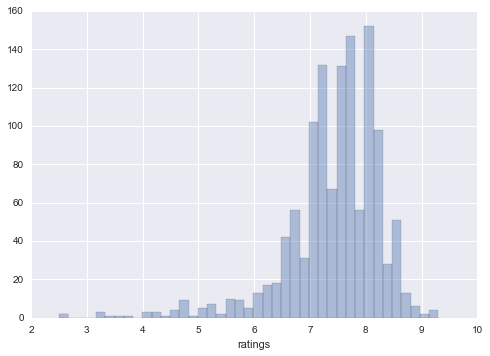

In [29]:
# displays a histogram of ratings
sns.distplot(movs.rating, kde=False, axlabel='ratings') 

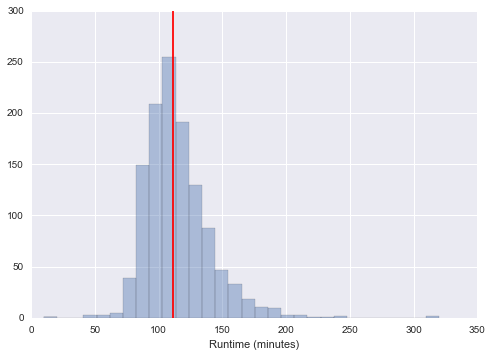

In [50]:
# displays a histogram of ratings
sns.distplot(movs[movs.runtime.notnull()].runtime, kde=False, axlabel='Runtime (minutes)',bins=30)
plt.axvline(np.median(movs[movs.runtime.notnull()].runtime),c='r')
plt.show()

In [10]:
# Average runtime by genre
pivot = movs.pivot_table(index='genre1',values='runtime')
pivot.sort_values()

genre1
Reality-TV      90.000000
Sci-Fi          94.500000
Film-Noir       96.500000
Animation       96.571429
Horror          99.738095
Comedy         103.625498
Family         105.666667
Documentary    105.836735
Fantasy        107.000000
Thriller       112.800000
History        113.500000
Crime          117.108434
Drama          118.060000
Action         121.303167
Mystery        121.444444
Adventure      128.610390
Biography      132.070423
Western        146.000000
News                  NaN
Sport                 NaN
Name: runtime, dtype: float64

In [11]:
# Most popular main actor
movs.cast1.value_counts()[:10]

Tom Cruise           18
Robert De Niro       15
Tom Hanks            12
Al Pacino            11
Leonardo DiCaprio     9
Dustin Hoffman        9
Christian Bale        9
Russell Crowe         8
Bruce Willis          8
Nicolas Cage          8
Name: cast1, dtype: int64

In [12]:
# Most popular directors
movs.director.value_counts()[:10]

Martin Scorsese      18
Steven Spielberg     17
Stanley Kubrick      10
Joel Coen             9
Alfred Hitchcock      9
Christopher Nolan     8
Wes Anderson          8
Peter Jackson         8
Quentin Tarantino     8
James Cameron         7
Name: director, dtype: int64

## Impute missing data

In [13]:
movs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 0 to 405
Data columns (total 16 columns):
rating      1233 non-null float64
tconst      1233 non-null object
title       1233 non-null object
year        1233 non-null float64
cast1       1231 non-null object
cast2       1226 non-null object
cast3       1225 non-null object
cast4       1217 non-null object
director    1227 non-null object
genre1      1226 non-null object
genre2      1050 non-null object
plot        1187 non-null object
date        1190 non-null object
runtime     1204 non-null float64
tagline     994 non-null object
writers     1196 non-null object
dtypes: float64(3), object(13)
memory usage: 163.8+ KB


 #### Impute missing runtime based on average runtime for similar genre

In [14]:
movs[movs.runtime.isnull()].genre1.value_counts()

Drama        9
Comedy       6
Action       3
History      2
Biography    1
Horror       1
News         1
Family       1
Adventure    1
Sport        1
Name: genre1, dtype: int64

In [15]:
for g in movs[movs.runtime.isnull()].genre1.value_counts().index:
    movs[movs['genre1']==g][movs[movs['genre1']==g].runtime.isnull()].runtime = pivot[g]

In [16]:
movs.dropna(subset=['cast1','cast2','year','runtime'],inplace=True,axis=0)

## Add features to the data

In [17]:
## Convert multiple columns to dummy
def multiple_cols_to_dummy(df, columns_list):
    # melt the columns
    melted_df = pd.melt(df,id_vars=['tconst'],value_vars=columns_list)
    dummies = pd.get_dummies(melted_df['value'])
    melted_df = pd.concat([melted_df,dummies],axis=1,)
    melted_df.drop(['variable','value'],axis=1,inplace=True)
    pivot = melted_df.pivot_table(index='tconst',aggfunc=sum).reset_index()
    df2 = pd.merge(df,pivot,left_on='tconst',right_on='tconst')
    df2.drop(columns_list,axis=1,inplace=True)
    return df2

In [18]:
movs2 = multiple_cols_to_dummy(movs,['cast1'])
movs2 = multiple_cols_to_dummy(movs2,['genre1','genre2'])
movs2 = multiple_cols_to_dummy(movs2,['director'])

In [19]:
movs2.drop(['tconst','title','plot','date','tagline','writers','cast2','cast3','cast4'],inplace=True,axis=1)

In [21]:
movs2.head(2)

,rating,year,runtime,A.J. Cook,Aamir Khan_x,Aaron Eckhart,Aaron Taylor-Johnson,Ace Marrero,Adam O'Brian,Adam Sandler,...,Wolfgang Reitherman,Woody Allen_y,Yasujirô Ozu,Yavuz Turgul,Yimou Zhang,Yorgos Lanthimos,Yuji Nakae,Zach Braff_y,Zack Snyder,Çagan Irmak
0,9.3,1994.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.2,1972.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
movs2.shape

(1200, 1432)

## Build tree model

In [24]:
# Define tree plotting function
from os import system
from sklearn.tree import export_graphviz

def build_tree_image(model, filename='tree.png'):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file = dotfile, feature_names = X.columns,filled=True,
                    rounded=True,special_characters=True)
    dotfile.close()
    system("dot -Tpng tree.dot -o {0}".format(filename))  # comment out this line if you don't have GraphViz yet

#### Build regression model

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5,min_samples_leaf=10,min_samples_split=40)
X = movs2.ix[:,1:]
y = movs2.ix[:,0]

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=5)

In [27]:
tree.fit(X_train,y_train)
build_tree_image(tree,'DecisionTreeRegressor.png')
y_pred = tree.predict(X_test)

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

0.124892381796


#### Build classifier model

In [29]:
# Define two categories: highly rated (above 8) and others (below 8)
y = [1 if score >= 8 else 0 for score in movs2.rating]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=5)

In [30]:
from sklearn.tree import DecisionTreeClassifier
ctree = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5)
ctree.fit(X_train,y_train)
build_tree_image(ctree,'DecisionTreeClassifier.png')
y_pred = ctree.predict(X_test)

In [31]:
# Measure accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.772727272727


In [32]:
# Classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       292
          1       0.58      0.49      0.53       104

avg / total       0.76      0.77      0.77       396



#### Optimize classifier with GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth':range(2,6),
    'min_samples_leaf':[5,10,15,20,25],
    'min_samples_split':[5,10,20,30,40]
}
gs = GridSearchCV(DecisionTreeClassifier(),params,n_jobs=-1,cv=5)

In [270]:
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 10, 20, 30, 40], 'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [271]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 5}

In [272]:
otree = DecisionTreeClassifier(max_depth=gs.best_params_["max_depth"],min_samples_leaf=gs.best_params_['min_samples_leaf'],min_samples_split=gs.best_params_['min_samples_split'])
otree.fit(X,y)
build_tree_image(otree,'DecisionTreeClassifier_optimized.png')
y_pred = otree.predict(X_test)

In [34]:
# Measure accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.772727272727


In [35]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       292
          1       0.58      0.49      0.53       104

avg / total       0.76      0.77      0.77       396



In [36]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat, index=['is_below_8', 'is_greater_equal_8'],columns=['predicted_below_8', 'predicted_greater_equal_8'])
confusion

,predicted_below_8,predicted_greater_equal_8
is_below_8,255,37
is_greater_equal_8,53,51


#### Build boosting model

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
params = {
    'learning_rate':[1,0.1,0.01],
    'min_samples_leaf':[1,5,10,15],
    'min_samples_split':[1,5,10,20],
    'max_depth':[3,4,5], 
}
gs_gb = GridSearchCV(GradientBoostingClassifier(),param_grid=params,n_jobs=-1)

In [39]:
gs_gb.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [1, 5, 10, 20], 'learning_rate': [1, 0.1, 0.01], 'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [40]:
gs_gb.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 1}

In [44]:
gbtree = GradientBoostingClassifier(max_depth=gs_gb.best_params_["max_depth"],min_samples_leaf=gs_gb.best_params_['min_samples_leaf'],min_samples_split=gs_gb.best_params_['min_samples_split'],learning_rate=gs_gb.best_params_['learning_rate'])
gbtree.fit(X,y)
y_pred = gbtree.predict(X_test)

In [45]:
# Measure accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.848484848485


In [46]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91       292
          1       1.00      0.42      0.59       104

avg / total       0.87      0.85      0.82       396



In [47]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat, index=['is_below_8', 'is_greater_equal_8'],columns=['predicted_below_8', 'predicted_greater_equal_8'])
confusion

,predicted_below_8,predicted_greater_equal_8
is_below_8,292,0
is_greater_equal_8,60,44
